In [1]:
from autolens.imaging import image as im
from autolens.imaging import mask
from autolens.lensing import ray_tracing
from autolens.model.galaxy import galaxy as g
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.lensing.plotters import ray_tracing_plotters
from autolens.imaging.plotters import imaging_plotters

# In this example, we'll use the 'imaging' module (imported as 'im') to 'simulate' an image of a strong lens made
# using a tracer. By simulate, we mean that it will appear as if we had observed it using a real telescope, 
# with this example making an image representative of Hubble Space Telescope imaging.

In [2]:
# To simulate an image, we need to model the telescope's optics. We'll do this by convolving the image with a
# Point-Spread Function, which we can simulate as a Gaussian using the imaging module.
psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.1, pixel_scale=0.1)

In [3]:
# To simulate an image, we use a special type of grid. This pads the grids 2D dimensions relative to the PSF-shape,
# to ensure that the edge's of our simulated image are not degraded.
image_plane_grids = mask.ImagingGrids.grids_for_simulation(shape=(100, 100), pixel_scale=0.1, psf_shape=psf.shape)
print(image_plane_grids.image.image_shape)
print(image_plane_grids.image.padded_shape)

(100, 100)
(110, 110)


In [4]:
# Now, lets setup our lens galaxy, source galaxy and tracer.
lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6, axis_ratio=0.7, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=45.0,
                                                        intensity=1.0, effective_radius=1.0, sersic_index=2.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=[image_plane_grids])

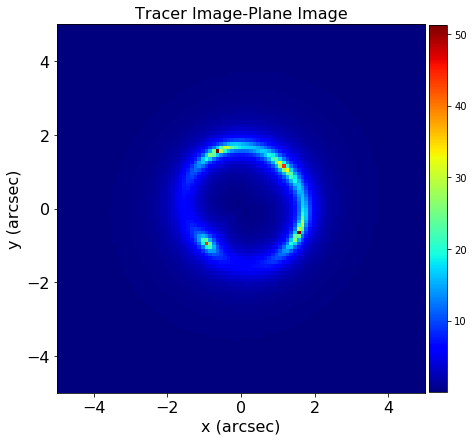

In [5]:
# Lets look at the tracer's image-plane image - this is the image we'll be simulating.
ray_tracing_plotters.plot_image_plane_image(tracer=tracer)

In [6]:
# To simulate the image, we don't use the image-plane image plotted above. Instead, we use an  image-plane image 
# which has been generated specifically for simulating an image, using the padded grid above that ensures 
# edge-effects do not degrade our simulation's PSF convolution.
print(tracer.image_plane_image.shape)
print(tracer.image_plane_image_for_simulation.shape)

(100, 100)
(110, 110)


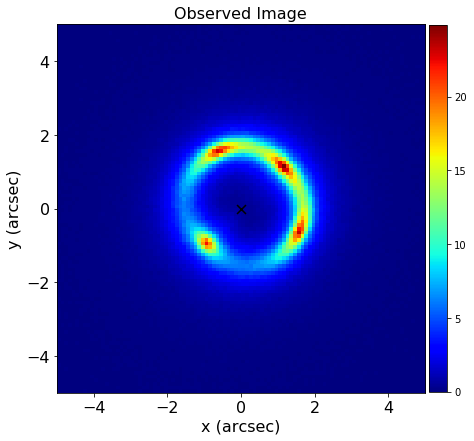

In [7]:
# Now, to simulate the image, we pass the tracer's image-plane image to the imaging module's simulate function. This
# adds the following effects:

# 1) Telescope optics: Using the Point Spread Function above.
# 2) The Background Sky: Although the image that is returned is automatically background sky subtracted.
# 3) Poisson noise: Due to the background sky, lens galaxy and source galaxy Poisson photon counts.

image_simulated = im.Image.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1, 
                                               exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

# Lets plot the image - we can see the image has been blurred due to the telescope optics and noise has been added.
imaging_plotters.plot_image(image=image_simulated)

In [9]:
# Finally, lets output these files to.fits files, we'll begin to analyze them in the next tutorial!
path = '/path/to/AutoLens/workspace/howtolens/chapter_1_introduction'

# If you are using Docker, the path you should use to output these images is (e.g. comment out this line)
# path = '/home/user/workspace/howtolens/chapter_1_introduction'

# If you arn't using docker, you need to change the path below to the chapter 2 directory and uncomment it
# path = '/path/to/user/workspace/howtolens/chapter_1_introduction'

im.output_imaging_to_fits(image=image_simulated, image_path=path+'/data/image.fits',
                                                 noise_map_path=path+'/data/noise_map.fits',
                                                 psf_path=path+'/data/psf.fits',
                          overwrite=True)
